In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
class Expert(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, x):
        return self.layer(x)

In [3]:
class Router(nn.Module):
    def __init__(self, embed_dim, num_experts=2):
        super().__init__()
        self.router = nn.Linear(embed_dim, num_experts)

    def forward(self, x):
        # x: (batch, seq_len, embed_dim)
        logits = self.router(x)               # (batch, seq_len, num_experts)
        weights = F.softmax(logits, dim=-1)   # routing weights
        return weights

In [4]:
class MoELayer(nn.Module):
    def __init__(self, embed_dim, num_experts=2):
        super().__init__()
        self.num_experts = num_experts
        
        self.experts = nn.ModuleList([Expert(embed_dim) for _ in range(num_experts)])
        self.router = Router(embed_dim, num_experts)

    def forward(self, x):
        # Routing weights for each token
        routing_weights = self.router(x)   # shape: (batch, seq_len, num_experts)

        # Apply all experts
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=-1)
        # shape: (batch, seq_len, embed_dim, num_experts)

        # Weighted sum across experts
        output = torch.sum(expert_outputs * routing_weights.unsqueeze(2), dim=-1)
        return output, routing_weights

In [5]:
embed_dim = 8
seq_len = 10

x = torch.randn(1, seq_len, embed_dim)

moe = MoELayer(embed_dim, num_experts=2)
output, routes = moe(x)

output.shape, routes.shape

(torch.Size([1, 10, 8]), torch.Size([1, 10, 2]))

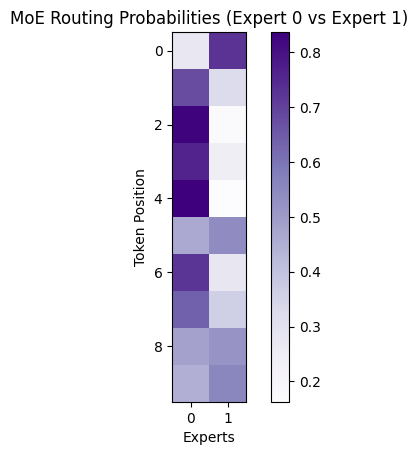

In [6]:
plt.imshow(routes[0].detach(), cmap='Purples')
plt.title("MoE Routing Probabilities (Expert 0 vs Expert 1)")
plt.xlabel("Experts")
plt.ylabel("Token Position")
plt.colorbar()
plt.show()

## Interpretation

In this notebook, I implemented a very small version of a Mixture-of-Experts (MoE) layer to understand how conditional computation works in modern LLMs. The model contains two main parts:

(1) Experts - small feed-forward networks that process the input, and

(2) A Router - which assigns a probability to each expert for every token.

The routing heatmap shows how different tokens are sent to different experts based on the router’s learned scores. Even though this example uses only two experts and random input, it clearly demonstrates the core idea behind MoE models: not all parts of the model are active for every token.

This helped me understand why large models like Mixtral or GLaM can scale to billions of parameters while keeping the actual computation per token relatively low. Building this minimal version made the concept much easier to grasp compared to reading it theoretically.